# VMT estimates: based on Production - Attraction matrix for all purpose trips (campo data)

### Preparation: import package

In [1]:
# a handy trick to get rid of deprecation warnings
import warnings
warnings.filterwarnings("ignore") 

In [2]:
from configparser import ConfigParser
import matplotlib.pyplot as plt
import pandas as pd
from census import Census
from us import states
import pyproj
import geopandas as gpd
import numpy as np
import re
import math

In [3]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
from shapely.geometry import Polygon
from math import radians, cos, sin, asin, sqrt, pi
from ipfn import ipfn
from haversine import haversine, Unit

In [4]:
from matplotlib.path import Path
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patheffects as PathEffects
from matplotlib import patheffects
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import palettable.matplotlib as mplpal
import palettable.colorbrewer.sequential as mplpals
from legendgram import legendgram
import mapclassify # used for reproducing the group of data in natural breaks
%matplotlib inline

### Preparation: updated stored files or links

In [5]:
# Read all environment variables
config = ConfigParser()
config.readfp(open(r'Config.py'))

census_api = config.get('General',"census_api") # api key
tx_state = config.get('General',"tx_state") #tx_state shapefile
tx_county  = config.get('General',"tx_county") # tx_county shapefile
tx_bgs = config.get('General',"tx_bgs") # tx_bgs shapefile

HOV2PA = config.get('Auto',"HOV2PA") #Production-Attaction (PA) Data
HOV3PA = config.get('Auto',"HOV3PA")#Production-Attaction (PA) Data
SOV = config.get('Auto',"SOV")#Production-Attaction (PA) Data

taz = config.get('Auto',"taz") # CAMPO-TAZ shapefile

hh = config.get('Auto',"hh") #households at TAZ level

distance = config.get('Auto',"distance") # the distance between each production-attraction pair 

In [6]:
# Set ACS API key
c = Census(census_api) 

In [7]:
# Access shapefile of Texas state
tx_state = gpd.read_file(tx_state) 

# Access shapefile of Texas county
tx_county = gpd.read_file(tx_county)

# Access shapefile of Texas census block groups
tx_bgs = gpd.read_file(tx_bgs)

In [8]:
# Read Production-Attaction (PA) Data 

HOV2_HBW = pd.read_excel(HOV2PA, sheet_name= "HBW")
HOV2_HBNW = pd.read_excel(HOV2PA, sheet_name= "HBNW")
HOV2_NHB = pd.read_excel(HOV2PA, sheet_name= "NHB")

HOV3_HBW = pd.read_excel(HOV3PA, sheet_name= "HBW")
HOV3_HBNW = pd.read_excel(HOV3PA, sheet_name= "HBNW")
HOV3_NHB = pd.read_excel(HOV3PA, sheet_name= "NHB")

SOV_HBW = pd.read_excel(SOV, sheet_name= "HBW")
SOV_HBNW = pd.read_excel(SOV, sheet_name= "HBNW")
SOV_NHB = pd.read_excel(SOV, sheet_name= "NHB")


In [9]:
# Read CAMPO-TAZ shapefile 
shapefile = gpd.read_file(taz)

In [10]:
# the number of households at TAZ level
hh_taz = pd.read_csv(hh) 

In [11]:
# Read the file of the distance between each production-attraction pair 
distance = pd.read_csv(distance)

## A.  Convert auto-trips data frames to PA matrix

In [12]:
#### add HBW trip data together####
HBWtrips = sum([HOV2_HBW, HOV3_HBW,SOV_HBW])
HBWtrips['Rows'] = range(1, 1+len(HBWtrips)) # re-rank the row with corrent index

# transpose dataframe
HBWtrips= HBWtrips.melt(id_vars=['Rows']) # internal trips transpose
 
HBWtrips.rename(columns = {'Rows':'origin', 'variable':'destination','value':'hbwtrips'}, inplace = True) # rename

# keep origin TAZ within CAMPO region (i.e., taz <= 2235)
HBWtrips = HBWtrips[(HBWtrips['origin'] <= 2235)]

#### add HBNW trip data together####

HBNWtrips = sum([HOV2_HBNW, HOV3_HBNW,SOV_HBNW])
HBNWtrips['Rows'] = range(1, 1+len(HBNWtrips)) # re-rank the row with corrent index

# transpose dataframe
HBNWtrips= HBNWtrips.melt(id_vars=['Rows']) # internal trips transpose
 
HBNWtrips.rename(columns = {'Rows':'origin', 'variable':'destination','value':'hbnwtrips'}, inplace = True) # rename

# keep origin TAZ within CAMPO region (i.e., taz <= 2235)
HBWtrips = HBWtrips[(HBWtrips['origin'] <= 2235)]

#### add NHB trip data together####
NHBtrips = sum([HOV2_NHB,HOV3_NHB,SOV_NHB])
NHBtrips['Rows'] = range(1, 1+len(NHBtrips)) # re-rank the row with corrent index

 # transpose dataframe
NHBtrips= NHBtrips.melt(id_vars=['Rows']) # internal trips transpose
 
NHBtrips.rename(columns = {'Rows':'origin', 'variable':'destination','value':'nhbtrips'}, inplace = True) # rename

# keep origin TAZ within CAMPO region (i.e., taz <= 2235)
NHBtrips = NHBtrips[(NHBtrips['origin'] <= 2235)]

In [13]:
# Get final combination of the trips associated with each PA pair
trips_taz = HBWtrips.merge(HBNWtrips, how = 'left', on = ['origin','destination']).merge(NHBtrips, how = 'left', on = ['origin','destination'])

In [14]:
trips_taz # check data

,origin,destination,hbwtrips,hbnwtrips,nhbtrips
0,1,1,2.750490,130.144613,2.358114
1,2,1,0.345772,1.219656,0.705035
2,3,1,2.057351,128.563990,6.890493
3,4,1,2.345774,17.697782,1.546680
4,5,1,0.550582,1.379625,0.696815
...,...,...,...,...,...
5343880,2231,2391,0.000000,0.000000,0.000000
5343881,2232,2391,0.000000,0.000000,0.000000
5343882,2233,2391,0.000000,0.000000,0.000000
5343883,2234,2391,0.000000,0.000000,0.000000


## B. In-vehicle distance 

#### Note: all internal distance are recalculated by ourselves; we take the radius as the distance of the PA pairs within the same TAZs

In [15]:
distance ['length_mile'] = distance ['dis_taz_meter']*0.000621 # convert length in meters to length in miles
distance = distance.drop (columns={'dis_taz_meter'})


# produce centroid for each taz in CAMPO shapefile 
shapefile.columns= shapefile.columns.str.lower() # lowercase
shapefile = shapefile.set_crs(4269, allow_override=True) #remember get geodataframe projected
shapefile = shapefile[['taz','geometry']] # specify columns to keep

def get_sqmi(row):
    feet = row.geometry.area
    return feet / 27878400 # sq_mile = sq_feet/27878400

shapefile ['area_taz'] = shapefile.to_crs({'init': 'epsg:4269'}).apply(get_sqmi, axis=1) # calculate total area
shapefile = shapefile.sort_values(by=['taz'])
shapefile.tail(5)

shapefile["centroid"] = shapefile ["geometry"].centroid
shapefile['lon'] = shapefile.centroid.x
shapefile['lat'] = shapefile.centroid.y
node_taz = shapefile [['taz','lon','lat']]
#node_taz.to_csv('node_taz.csv',index=False)

In [16]:
### fill-in all missing distance variable values ###

# filter out the PA pairs having valid distance
distance2 = distance.loc [(distance['length_mile'] != 0)] # in this case, we have alreay make sure that all 0 mile distances belong to the OD paris with same block groups geoids

# identify PA pairs (different origin and destination tazs) with missing distance, we use haversine distance to replace the missing value 
distance0 = distance.loc [(distance['length_mile'] == 0) & (distance['origin_taz'] != distance['dest_taz'])] # in this case, we have alreay make sure that all 0 mile distances belong to the OD paris with same block groups geoids
distance0 = distance0.merge (node_taz, how='left', left_on='origin_taz', right_on ='taz')
distance0 = distance0.rename(columns={"lon":"o_long","lat":"o_lat" })
distance0 = distance0.drop(columns={'taz'})

distance0 = distance0.merge (node_taz, how='left', left_on='dest_taz', right_on ='taz')
distance0 = distance0.rename(columns={"lon":"d_long","lat":"d_lat" })
distance0 = distance0.drop(columns={'taz'})

def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in miles is 3963
    mile = 3963* c
    return mile

# Creating a new column to generate the output by passing lat/long information to Haversine Equation
distance0 ['length_mile'] = distance0.apply(lambda x: haversine(x['o_long'], x['o_lat'], x['d_long'], x['d_lat']) , axis=1)
distance0 = distance0.drop(columns={'o_long','o_lat','d_long','d_lat'})

# identify OD pairs with 0 distance because these OD pairs are from the same bgs, to recalculate the corresponding distance 
# we assume that each tazs as a circle and the radius of that would be the average travel distance within the tazs 

distance1 = distance.loc [(distance['length_mile'] == 0) & (distance['origin_taz'] == distance['dest_taz'])] # in this case, we have alreay make sure that all 0 mile distances belong to the OD paris with same block groups geoids

distance1 = distance1 .merge (shapefile, how='left', left_on='origin_taz', right_on ='taz')
distance1 = distance1 [['origin_taz','dest_taz','length_mile','area_taz']]


# calculate the distance (i.e. radius of the area) for origin_taz = dest_taz

distance1['length_mile'] = np.sqrt (distance1['area_taz']/pi)
distance1 = distance1.drop(columns={'area_taz'})


# concate the above all 

distance =  pd.concat([distance0, distance1, distance2],ignore_index=True)
distance = distance.rename(columns={"origin_taz":"origin","dest_taz":"destination" })


In [17]:
### merge distance dataframe and the trips dataframe ###

trips_taz.origin = trips_taz.origin.astype(str) #convert dtype of columns before merging
trips_taz.destination = trips_taz.destination.astype(str) #convert dtype of columns before merging

distance.origin = distance.origin.astype(str)
distance.destination = distance.destination.astype(str)


# merge production and attractions
campo_pa = trips_taz.merge(distance, on=["origin","destination"])

# Produce VMT for each OD taz pairs
campo_pa ['hbwvmt'] = campo_pa ['hbwtrips'] * campo_pa ['length_mile']
campo_pa ['hbnwvmt'] = campo_pa ['hbnwtrips'] * campo_pa ['length_mile']
campo_pa ['nhbvmt'] = campo_pa ['nhbtrips'] * campo_pa ['length_mile']

campo_pa.origin = campo_pa.origin.astype(str)
campo_pa.destination = campo_pa.destination.astype(str)

In [18]:
campo_pa = campo_pa.round(4)
campo_pa.to_csv('campo_pa1.csv',index=False) # save it to the file 

In [19]:
campo_pa.sort_values('length_mile') # check data

,origin,destination,hbwtrips,hbnwtrips,nhbtrips,length_mile,hbwvmt,hbnwvmt,nhbvmt
0,1,1,2.7505,130.1446,2.3581,0.0000,0.0,0.0002,0.0
1647932,738,738,0.5402,4.1617,0.0964,0.0000,0.0,0.0000,0.0
1650168,739,739,1.5904,23.4845,0.5661,0.0000,0.0,0.0000,0.0
1652404,740,740,3.1783,18.7652,0.5548,0.0000,0.0,0.0000,0.0
1654640,741,741,0.1991,1.5462,0.0118,0.0000,0.0,0.0000,0.0
...,...,...,...,...,...,...,...,...,...
2898560,2001,1297,0.0000,0.0001,0.0000,129.3673,0.0,0.0107,0.0
4647707,1143,2080,0.0000,0.0000,0.0000,131.2055,0.0,0.0000,0.0
2554449,2080,1143,0.0000,0.0000,0.0000,131.2111,0.0,0.0000,0.0
4471142,1143,2001,0.0000,0.0000,0.0000,131.3508,0.0,0.0000,0.0


In [20]:
campo_pa.describe().round(2) # summary statistics

,hbwtrips,hbnwtrips,nhbtrips,length_mile,hbwvmt,hbnwvmt,nhbvmt
count,4995225.00,4995225.00,4995225.00,4995225.00,4995225.00,4995225.00,4995225.00
mean,0.26,0.65,0.35,33.96,3.69,4.60,1.81
std,1.56,10.67,5.44,19.74,16.71,66.14,18.67
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,18.68,0.02,0.00,0.00
50%,0.01,0.00,0.00,31.77,0.29,0.00,0.00
75%,0.09,0.01,0.01,46.55,1.93,0.27,0.12
max,468.02,3494.12,2579.90,131.39,2629.05,32228.99,8072.96


## C. Convert all-purpose VMT/HH at the TAZ level to the bgs level

### C.1) Get total VMT associated with each origin TAZs

In [21]:
vmt_taz = campo_pa.groupby(['origin']).sum()
vmt_taz = vmt_taz[['hbwtrips','hbwvmt','hbnwtrips','hbnwvmt','nhbtrips','nhbvmt']]
vmt_taz.reset_index(inplace=True)

In [22]:
vmt_taz.describe().round(2) # check data

,hbwtrips,hbwvmt,hbnwtrips,hbnwvmt,nhbtrips,nhbvmt
count,2235.00,2235.00,2235.00,2235.00,2235.00,2235.00
mean,576.32,8239.98,1451.37,10291.39,791.95,4049.75
std,838.66,12390.22,2071.35,16428.12,1609.25,7715.03
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,53.62,898.89,133.17,1080.36,43.49,295.43
50%,251.89,3744.96,649.33,4584.35,259.30,1438.55
75%,746.22,10299.70,1896.59,12416.12,856.59,4332.70
max,6371.48,120457.10,17411.07,245482.28,35400.94,134103.06


### C.2) Get total VMT/hh associated with each origin TAZs

In [23]:
# Mapping TAZ level vmt/hh
hh_taz.columns= hh_taz.columns.str.lower() # lowercase
hh_taz = hh_taz.rename(columns={'hh15': 'hh_taz'})

##Convert VMT/HH at TAZ level 
vmt_taz.origin = vmt_taz.origin.astype(str)
hh_taz.taz =hh_taz.taz.astype(str)

vmt_hhtaz= vmt_taz.merge(hh_taz, how ='left', left_on = 'origin',right_on ='taz')
vmt_hhtaz['hbwvmthh_taz'] = vmt_hhtaz['hbwvmt'] / vmt_hhtaz['hh_taz']
vmt_hhtaz['hbnwvmthh_taz'] = vmt_hhtaz['hbnwvmt'] / vmt_hhtaz['hh_taz']
vmt_hhtaz['nhbvmthh_taz'] = vmt_hhtaz['nhbvmt'] / vmt_hhtaz['hh_taz']

vmt_hhtaz = vmt_hhtaz.drop (columns = {'taz','hhsize15'})


### C.3) VMT/HH at the TAZ level

In [24]:
vmt_hhtaz['totvmthh_taz'] = vmt_hhtaz['hbnwvmthh_taz'] + vmt_hhtaz['hbwvmthh_taz'] 
vmt_hhtaz.replace([np.inf, -np.inf], 0, inplace=True)

In [25]:
vmt_hhtaz.describe().round(2) 

,hbwtrips,hbwvmt,hbnwtrips,hbnwvmt,nhbtrips,nhbvmt,hh_taz,hbwvmthh_taz,hbnwvmthh_taz,nhbvmthh_taz,totvmthh_taz
count,2235.00,2235.00,2235.00,2235.00,2235.00,2235.00,2235.00,2039.00,2043.00,2204.00,2039.00
mean,576.32,8239.98,1451.37,10291.39,791.95,4049.75,318.51,30.05,41.84,126.99,71.98
std,838.66,12390.22,2071.35,16428.12,1609.25,7715.03,446.26,14.53,50.62,1813.17,56.57
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.62,0.00,0.00,14.74
25%,53.62,898.89,133.17,1080.36,43.49,295.43,31.50,17.05,20.77,1.99,40.20
50%,251.89,3744.96,649.33,4584.35,259.30,1438.55,142.00,29.15,33.34,4.60,63.53
75%,746.22,10299.70,1896.59,12416.12,856.59,4332.70,431.50,40.75,50.29,14.26,90.81
max,6371.48,120457.10,17411.07,245482.28,35400.94,134103.06,3768.00,80.89,1005.31,61471.97,1031.27


###### Set a threshold for households (only consider households greater than 20 and total vmt/hh <1000)

In [26]:
vmt_hhtaz.loc[(vmt_hhtaz['hbwvmthh_taz'] > 500)  , 'hbwvmthh_taz'] = 500
vmt_hhtaz.loc[(vmt_hhtaz['hbnwvmthh_taz'] > 500)  , 'hbnwvmthh_taz'] = 500
vmt_hhtaz.loc[(vmt_hhtaz['totvmthh_taz'] > 1000) , 'totvmthh_taz'] = 1000

vmt_hhtaz.loc[(vmt_hhtaz['hh_taz'] < 20) , 'hbnwvmthh_taz'] = 50
vmt_hhtaz.loc[(vmt_hhtaz['hh_taz'] < 20) , 'hbwvmthh_taz'] = 50
vmt_hhtaz.loc[(vmt_hhtaz['hh_taz'] < 20) , 'nhbvmthh_taz'] = 50
vmt_hhtaz.loc[(vmt_hhtaz['hh_taz'] < 20) , 'totvmthh_taz'] = 50

### C.4) convert VMT/HH per year at TAZ level to BGS level, based on the area overlapping ratio between TAZ level and block group level

##### load TX State and county boundary

In [27]:
### State boundary ###
#### Access shapefile of Texas state, reproject shapefile to the EPSG identifier of NAD83
tx_state  = tx_state.to_crs(epsg = 4269)

#clean data through keeping only necessary variables
tx_state  = tx_state [['GEOID','NAME','geometry']]

# rename  columns to lower case
tx_state.columns= tx_state.columns.str.lower()


# narrow down to TX state

state = ['48']
tx_state   = tx_state [tx_state ['geoid'].isin(state)] 

tx_state ['namelsad'] = tx_state ['name'] # in order to plotting the names


### County boundary ###
# Access shapefile of Texas county, reproject shapefile to the EPSG identifier of NAD83
tx_county = tx_county.to_crs(epsg = 4269)

#clean data through keeping only necessary variables
tx_county = tx_county[['GEOID','NAME','geometry']]

# rename  columns to lower case
tx_county.columns= tx_county.columns.str.lower()


# narrow down to CAMPO county

county = ['48021', '48053', '48055','48209','48453','48491']
campo_county = tx_county[tx_county['geoid'].isin(county)]
campo_county.reset_index(drop=True, inplace=True)

campo_county ['namelsad'] = campo_county ['name'] # in order to plotting the names


### Block groups boundary ###
# Access shapefile of Texas census block groups, reproject shapefile to the EPSG identifier of NAD83
tx_bgs = tx_bgs.to_crs(epsg = 4269)

#clean data through keeping only necessary variables

tx_bgs = tx_bgs[['GEOID', 'ALAND','geometry']]

# rename  columns to lower case
tx_bgs.columns= tx_bgs.columns.str.lower()


#narrow down to the bgs in campo
campo = tx_bgs.copy()
campo ['county'] = campo ['geoid'].str[:5]

county = ['48021', '48053', '48055','48209','48453','48491']
campo = campo[campo['county'].isin(county)]
campo.reset_index(drop=True, inplace=True)

##### load ACS shapefile data

In [28]:
######Load ACS Data at the block groups level #####

# census data download
bgs_census = c.acs5.state_county_blockgroup(fields = ('NAME', 'B08301_001E','B11001_001E'), # number of household:"B11001_001E",commuters with all travel mean "B08301_001E", 
                                            state_fips = states.TX.fips,
                                            county_fips = "*",
                                            blockgroup = "*",
                                            year = 2019)
# Create a dataframe for the downloaded census data
bgs_census = pd.DataFrame(bgs_census)

# filter needed county 
# (CAMPO's counties fips:#Bastrop =021,Burnet=053,Caldwell=055,Hays =209,Travis=453,Williamson = 491)

county = ['021', '053', '055','209','453','491']
bgs_census = bgs_census[bgs_census['county'].isin(county)] 

# rename the column to get more intuitive sense
bgs_census.rename(columns={'B08301_001E': 'bgs_commuter', 'B11001_001E':'HH_bgs'}, inplace=True)

# Show the dataframe
# print('Shape: ', bgs_census.shape)
# bgs_census.info() # review 

### Combine state, county, tract, and block group columns to create a new string and assign it to a new column ###

bgs_census["geoid_bgs"] = bgs_census["state"] + bgs_census["county"] + bgs_census ["tract"] + bgs_census ["block group"]

# Remove columns that are no longer needed
bgs_census = bgs_census.drop(columns = ["state", "county","tract","block group","NAME"])

# change the order of the column
cols = bgs_census.columns.tolist()
cols = cols[-2:] + cols[:-2] #move "geoid" and "county" columns forward to the front
bgs_census = bgs_census[cols] #apply the new column sequence 


### Join the attributes of the ACS and TIGER/LINE dataframes together ###

bgs_census.geoid_bgs = bgs_census.geoid_bgs.astype(str) #convert dtype of columns before merging
tx_bgs.geoid = tx_bgs.geoid.astype(str) #convert dtype of columns before merging

merge = tx_bgs.merge(bgs_census, how = 'left', left_on = "geoid",right_on = "geoid_bgs")

merge ['area_bgs'] = merge.to_crs({'init': 'epsg:4269'}).apply(get_sqmi, axis=1) # calculate total area

# re-assign the number of households to some block groups of school region
merge.loc[merge.geoid_bgs == "484530006012", "HH_bgs"] = 1400
merge.loc[merge.geoid_bgs == "482090102003", "HH_bgs"] = 1000
merge.loc[merge.geoid_bgs == "482090108072", "HH_bgs"] = 1000

#clean data
merge = merge.dropna()
merge = merge.drop(columns = 'geoid_bgs')

# Show result
print(merge.head(2))
print('Shape: ', merge.shape);


            geoid     aland  \
414  480539607001  25087836   
526  480539603002  10257531   

                                              geometry  HH_bgs  bgs_commuter  \
414  POLYGON ((-98.29806 30.59752, -98.29801 30.597...   606.0         621.0   
526  POLYGON ((-98.23087 30.76786, -98.23051 30.767...   393.0         684.0   

         area_bgs  
414  8.521472e-11  
526  3.467412e-11  
Shape:  (994, 6)


##### Spatial join (intersect) : block groups level and CAMPO TAZ level


In [29]:
## alternative code for overlapping: taz_bgs =gpd.sjoin(shapefile, merge, op="intersects") 

taz_bgs = gpd.overlay(shapefile, merge,how='intersection') 
taz_bgs['area_overlap'] = taz_bgs.apply(get_sqmi, axis=1)


taz_bgs.taz = taz_bgs.taz.astype(str)
taz_bgs.geoid  = taz_bgs.geoid.astype(str)

# allocate households at bgs level to TAZs based on the overlapping ratio of area
taz_bgs ['area_weights'] = taz_bgs ['area_overlap']/taz_bgs ['area_bgs']

shapefile.taz = shapefile.taz.astype(str) #convert dtype of columns before merging
vmt_hhtaz.origin = vmt_hhtaz.origin.astype(str) #convert dtype of columns before merging

vmt_hhtaz1 = shapefile.merge (vmt_hhtaz,how = 'left', left_on = 'taz', right_on = 'origin')

In [30]:
# merge back with the dataframe having overlapping area ratio
area_ratio = taz_bgs [['taz','geoid','area_taz','area_overlap','area_weights']]

vmt_hhtaz.origin = vmt_hhtaz.origin.astype(str)
area_ratio.taz =area_ratio.taz.astype(str)

# used the intersection ratio to indicate the amount of vmt/hh at TAZ level that belongs to their corresponding bgs
vmt_hhbgs= vmt_hhtaz.merge(area_ratio, how ='left', left_on = 'origin',right_on ='taz')

vmt_hhbgs ['hbw_vmthh_intersection'] = vmt_hhbgs ['hbwvmthh_taz'] * (vmt_hhbgs  ['area_overlap']/vmt_hhbgs ['area_taz']) 
vmt_hhbgs ['hbnw_vmthh_intersection'] = vmt_hhbgs ['hbnwvmthh_taz'] * (vmt_hhbgs  ['area_overlap']/vmt_hhbgs ['area_taz']) 
vmt_hhbgs ['nhb_vmthh_intersection'] = vmt_hhbgs ['nhbvmthh_taz'] * (vmt_hhbgs  ['area_overlap']/vmt_hhbgs ['area_taz']) 
vmt_hhbgs ['tot_vmthh_intersection'] = vmt_hhbgs ['totvmthh_taz'] * (vmt_hhbgs  ['area_overlap']/vmt_hhbgs ['area_taz']) 


# multiply the vmt/hh of the area intersection by the area weights: "vmt_hhbgs ['hbw_vmthh_bgs_day'] * the area weights" 
vmt_hhbgs ['hbw_vmthh_bgs_day'] = vmt_hhbgs ['hbw_vmthh_intersection'] * vmt_hhbgs ['area_weights'] 
vmt_hhbgs ['hbnw_vmthh_bgs_day'] = vmt_hhbgs ['hbnw_vmthh_intersection'] * vmt_hhbgs ['area_weights'] 
vmt_hhbgs ['nhb_vmthh_bgs_day'] = vmt_hhbgs ['nhb_vmthh_intersection'] * vmt_hhbgs ['area_weights'] 
vmt_hhbgs ['tot_vmthh_bgs_day'] = vmt_hhbgs ['tot_vmthh_intersection'] * vmt_hhbgs ['area_weights'] 


# convert VMT/hh per day to VMT/hh per year: mutiply by the number of weekdays [and (0.6* the number of weekend days)]
vmt_hhbgs ['hbw_vmthh_bgs_year'] = (vmt_hhbgs ['hbw_vmthh_bgs_day'] * 261) + (vmt_hhbgs ['hbw_vmthh_bgs_day']*0.6*104)
vmt_hhbgs ['hbnw_vmthh_bgs_year'] = (vmt_hhbgs ['hbnw_vmthh_bgs_day'] * 261) + (vmt_hhbgs ['hbnw_vmthh_bgs_day']*0.6*104)
vmt_hhbgs ['tot_vmthh_bgs_year'] = (vmt_hhbgs ['tot_vmthh_bgs_day'] * 261) + (vmt_hhbgs ['tot_vmthh_bgs_day']*0.6*104)

allvmt_hhbgs = vmt_hhbgs.groupby(['geoid']).sum() # use groupby to get the total number of vmt/hh in each block group 
allvmt_hhbgs.reset_index(inplace=True)

In [31]:
vmt = merge.merge(allvmt_hhbgs, how = 'left', on = 'geoid')

###### Data clean: Set a threshold for households (only consider bgs with households greated than 0 and with commuter >0)

In [32]:
vmt.loc[(vmt['HH_bgs'] <30)&(vmt['bgs_commuter']==0),['tot_vmthh_bgs_year']] = 0
vmt.loc[(vmt['HH_bgs'] <30)&(vmt['bgs_commuter']==0),'hbnw_vmthh_bgs_year'] = 0
vmt.loc[(vmt['HH_bgs'] <30)&(vmt['bgs_commuter']==0),'hbw_vmthh_bgs_year'] = 0
vmt.loc[(vmt['HH_bgs'] <30)&(vmt['bgs_commuter']==0),'tot_vmthh_bgs_day'] = 0
vmt.loc[(vmt['HH_bgs'] <30)&(vmt['bgs_commuter']==0),'hbnw_vmthh_bgs_day'] = 0
vmt.loc[(vmt['HH_bgs'] <30)&(vmt['bgs_commuter']==0),'hbw_vmthh_bgs_day'] = 0

vmt.loc[(vmt['HH_bgs'] ==0),['tot_vmthh_bgs_year']] = 0
vmt.loc[(vmt['HH_bgs'] ==0),['hbnw_vmthh_bgs_year']] = 0
vmt.loc[(vmt['HH_bgs'] ==0),['hbw_vmthh_bgs_year']] = 0
vmt.loc[(vmt['HH_bgs'] ==0),['tot_vmthh_bgs_day']] = 0
vmt.loc[(vmt['HH_bgs'] ==0),['hbnw_vmthh_bgs_day']] = 0
vmt.loc[(vmt['HH_bgs'] ==0),['hbw_vmthh_bgs_day']] = 0


In [33]:
# clean the data
allvmt_hhbgs= vmt[['geoid','hbw_vmthh_bgs_day', 'hbnw_vmthh_bgs_day','tot_vmthh_bgs_day',
                            'hbw_vmthh_bgs_year','hbnw_vmthh_bgs_year','tot_vmthh_bgs_year'
                           ]]


In [34]:
allvmt_hhbgs.to_csv('VMT.csv',index=False) #save it to the csv file

In [35]:
allvmt_hhbgs

,geoid,hbw_vmthh_bgs_day,hbnw_vmthh_bgs_day,tot_vmthh_bgs_day,hbw_vmthh_bgs_year,hbnw_vmthh_bgs_year,tot_vmthh_bgs_year
0,480539607001,11.759093,23.058462,34.817402,3802.890800,7457.106600,11259.947651
1,480539603002,19.652907,38.436999,58.089906,6355.750131,12430.525630,18786.275761
2,480539601002,40.688632,62.002027,102.690659,13158.703510,20051.455673,33210.159183
3,480539608001,44.496605,65.658648,101.635693,14390.202196,21234.006758,32868.983010
4,480539604003,33.939066,55.997622,86.726725,10975.894061,18109.630826,28047.422842
...,...,...,...,...,...,...,...
989,484530017512,17.522421,20.574689,38.097110,5666.750870,6653.854549,12320.605419
990,484530017522,8.201276,11.993766,20.124780,2652.292580,3878.783921,6508.353968
991,484530017462,9.135991,11.639871,20.775862,2954.579598,3764.334186,6718.913784
992,484530017473,9.198116,12.662723,21.860839,2974.670788,4095.124578,7069.795366


## D. Mapping

 Note: use "vmt" dataframe becasue it has geometry

#### Daily home-based work VMT/HH AND Yearly home-based non-work VMT/HH 


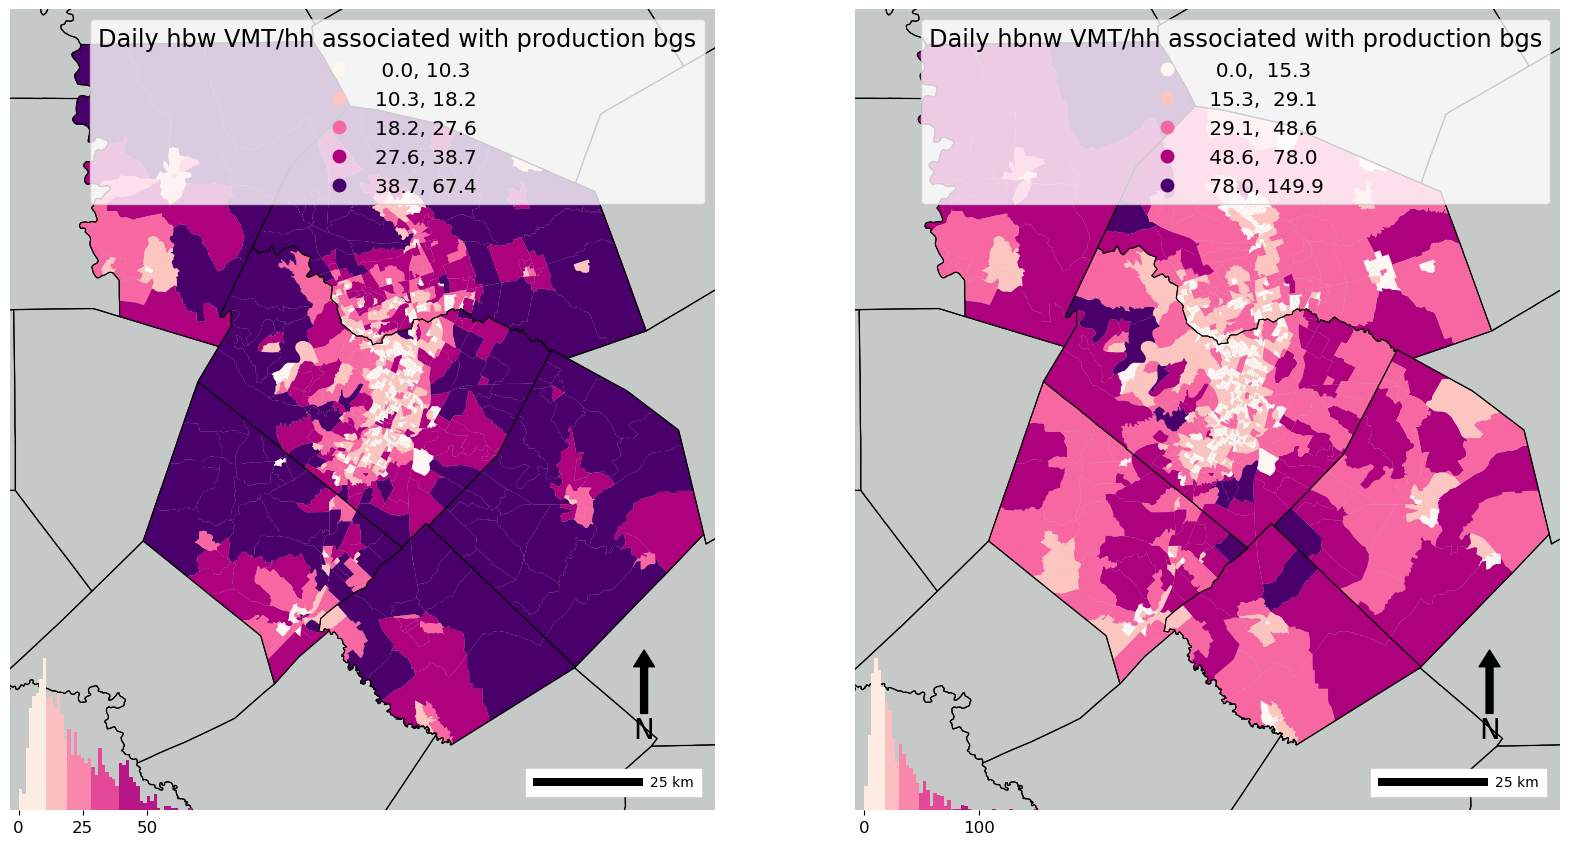

In [36]:


fig, [ax1, ax2] = plt.subplots(nrows=1,ncols=2,figsize=(20, 20)) # set plot size

 
ax1.axis([-98.6,-97,29.5,31.1]) # set axis
ax2.axis([-98.6,-97,29.5,31.1])




### Plot data : hbw at the bgs level ###

# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
vmt.plot(column = 'hbw_vmthh_bgs_day',
            ax = ax1,
            cmap = "RdPu",
            scheme='natural_breaks',
            legend = True,
           legend_kwds=(dict(fontsize='x-large',fmt="{:.1f}")))
ax1.get_legend().set_title("Daily hbw VMT/hh associated with production bgs",prop={'size':'xx-large'}) # add legend title

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax =ax1, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax =ax1, zorder=2)


ax1.axis('off') #Get rid of grids, and x/y axis

## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=vmt.hbw_vmthh_bgs_day, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax1, # the axis to add the legend
           y = vmt.hbw_vmthh_bgs_day, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

# add scalre bar
ax1.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax1.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax1.transAxes)


### Plot data : hbnw at the bgs level ###
 

# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
vmt.plot(column = 'hbnw_vmthh_bgs_day',
            ax = ax2,
            cmap = "RdPu",
            scheme='natural_breaks',
            legend = True,
           legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")))
ax2.get_legend().set_title("Daily hbnw VMT/hh associated with production bgs",prop={'size':'xx-large'}) # add legend title

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax =ax2, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax =ax2, zorder=2)


ax2.axis('off') #Get rid of grids, and x/y axis

## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=vmt.hbnw_vmthh_bgs_day, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax2, # the axis to add the legend
           y = vmt.hbnw_vmthh_bgs_day, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

# add scalre bar
ax2.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax2.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax2.transAxes)

fig.savefig('images/daily_hbw_hbnw_vmt_hh.png')

####  Yearly home-based work VMT/HH AND Yearly home-based non-work VMT/HH 


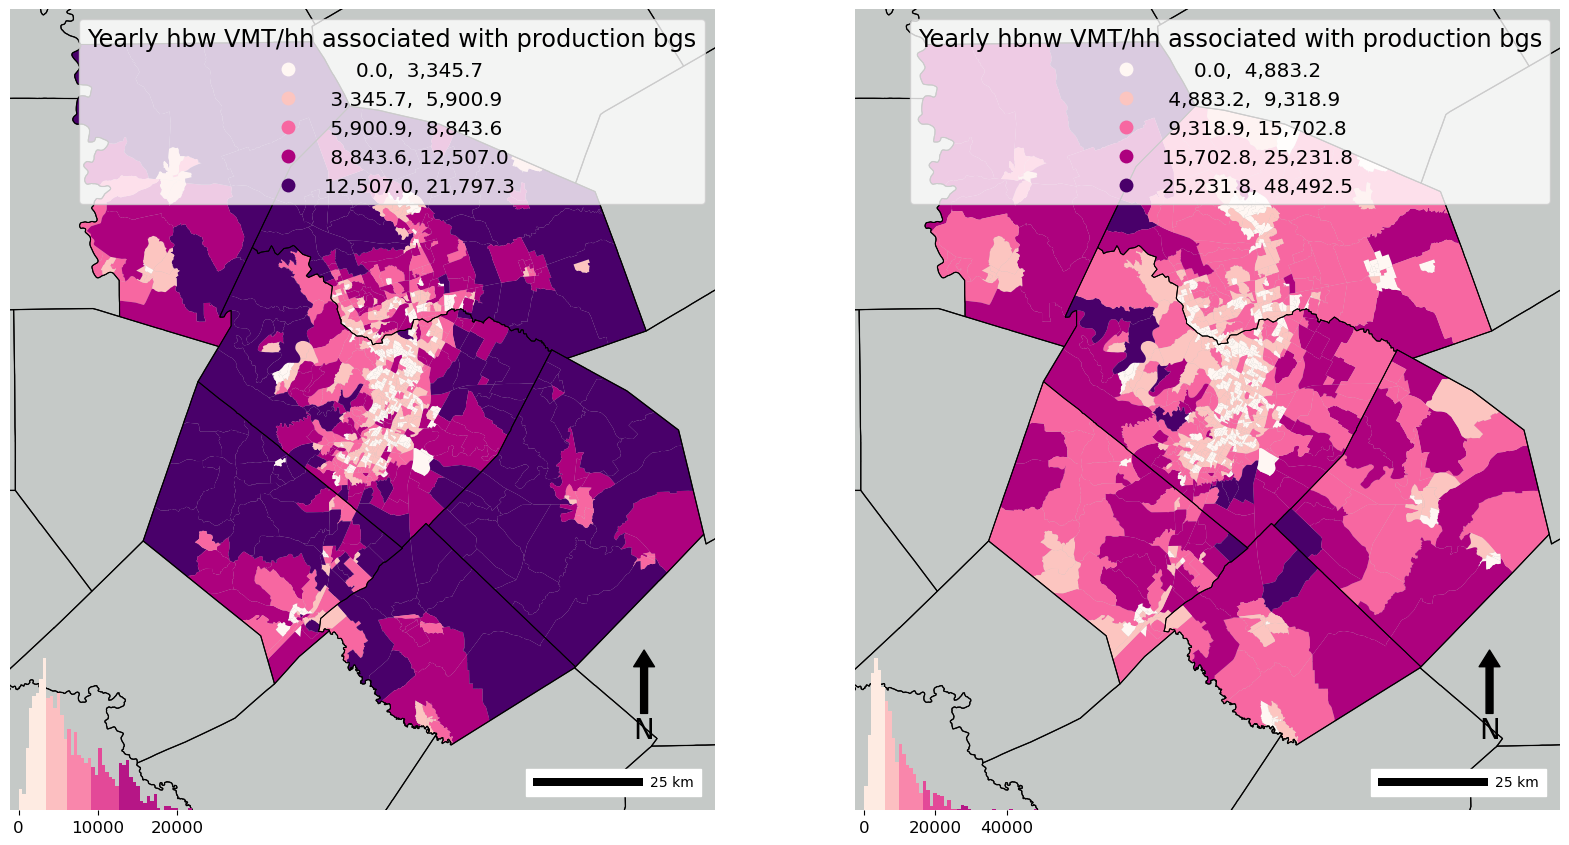

In [37]:
fig, [ax1, ax2] = plt.subplots(nrows=1,ncols=2,figsize=(20, 20)) # set plot size

 
ax1.axis([-98.6,-97,29.5,31.1]) # set axis
ax2.axis([-98.6,-97,29.5,31.1])




### Plot data : hbw at the bgs level ###

# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
vmt.plot(column = 'hbw_vmthh_bgs_year',
            ax = ax1,
            cmap = "RdPu",
            scheme='natural_breaks',
            legend = True,
           legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")))
ax1.get_legend().set_title("Yearly hbw VMT/hh associated with production bgs",prop={'size':'xx-large'}) # add legend title

tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax =ax1, zorder=0)
# county boundary
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax =ax1, zorder=2)


ax1.axis('off') #Get rid of grids, and x/y axis

## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=vmt.hbw_vmthh_bgs_year, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax1, # the axis to add the legend
           y = vmt.hbw_vmthh_bgs_year, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

# add scalre bar
ax1.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax1.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax1.transAxes)


### Plot data : hbnw at the bgs level ###

# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
vmt.plot(column = 'hbnw_vmthh_bgs_year',
            ax = ax2,
            cmap = "RdPu",
            scheme='natural_breaks',
            legend = True,
           legend_kwds=(dict(fontsize='x-large',fmt="{:,.1f}")))
ax2.get_legend().set_title("Yearly hbnw VMT/hh associated with production bgs",prop={'size':'xx-large'}) # add legend title

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax =ax2, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax =ax2, zorder=2)


ax2.axis('off') #Get rid of grids, and x/y axis

## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=vmt.hbnw_vmthh_bgs_year, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax2, # the axis to add the legend
           y = vmt.hbnw_vmthh_bgs_year, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

# add scalre bar
ax2.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax2.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax2.transAxes)


fig.savefig('images/yearly_hbw_hbnw_vmt_hh.png')

#### Yearly total VMT/HH at the block groups level


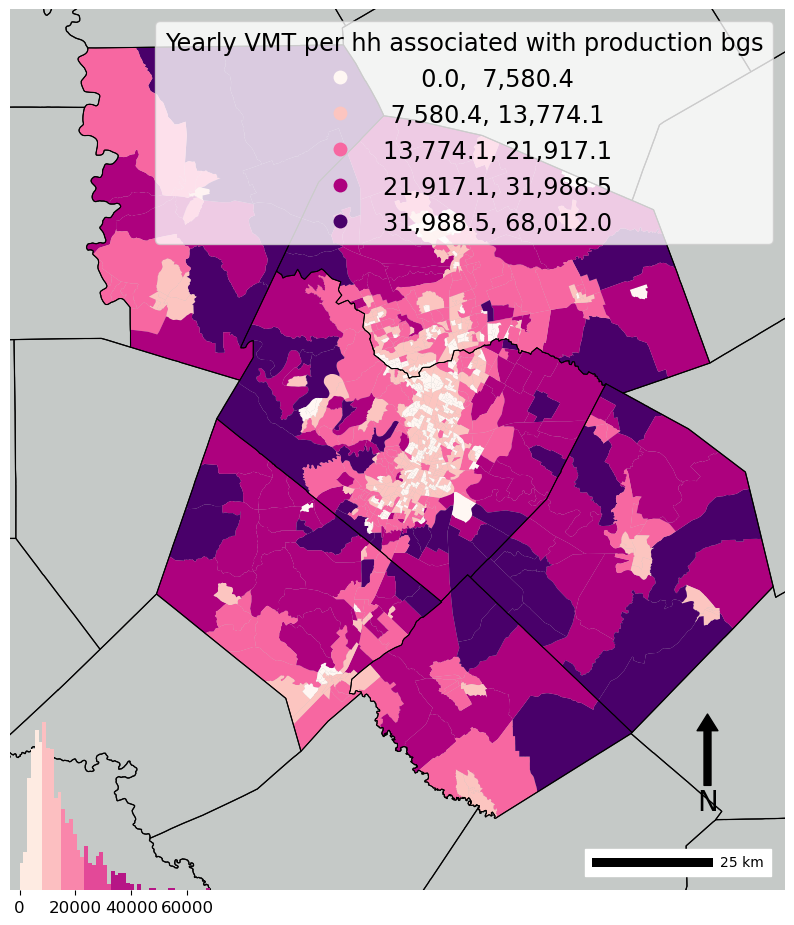

In [38]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10, 20)) # set plot size


ax.axis([-98.6,-97,29.5,31.1]) # set axis


# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
vmt.plot(column = 'tot_vmthh_bgs_year',
            ax = ax,
            cmap = "RdPu",
            scheme='natural_breaks',
            legend = True,
           legend_kwds=(dict(fontsize='xx-large',fmt="{:,.1f}")))
ax.get_legend().set_title("Yearly VMT per hh associated with production bgs",prop={'size':'xx-large'}) # add legend title

# county boundary
tx_county.plot(color='#C5C9C7',edgecolor='grey',linewidth = 1,ax =ax, zorder=0)
tx_county.to_crs(epsg = 4269).geometry.boundary.plot(color=None,edgecolor='k',linewidth = 0.7,ax =ax, zorder=2)


ax.axis('off') #Get rid of grids, and x/y axis

## add histogram as legend
scheme = mapclassify.NaturalBreaks(y=vmt.tot_vmthh_bgs_year, k=5).bins # #extract the natural_break threshold values and get corresponding bins

legendgram(f =fig, # grab the figure, we need it
           ax = ax, # the axis to add the legend
           y = vmt.tot_vmthh_bgs_year, # the attribute to map
           breaks = scheme, 
           # the natural breaks to induce color differences on
           pal = mplpals.RdPu_5, # the palette to use
          )

# add scalre bar
ax.add_artist(ScaleBar(100,"km", dimension="si-length", # add scale bar
                    length_fraction=0.25,scale_loc="right",border_pad=1,pad=0.5,location = "lower right"))

# add North arrow
x, y, arrow_length = 0.9, 0.2, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

fig.savefig('images/yearly_vmt_hh.png')